In [1]:
# pip install jcopdl if you haven't already installed it

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

import torch
from torch import nn, optim
from jcopdl.callback import Callback

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# Import Data

In [2]:
df = load_iris(as_frame=True)['frame']

In [3]:
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [4]:
iris = load_iris()
X = iris.data
y = iris.target

In [5]:
df.target.value_counts()

0    50
1    50
2    50
Name: target, dtype: int64

# Dataset Splitting

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((120, 4), (30, 4), (120,), (30,))

# Dataset and Dataloader

In [7]:
X_train = torch.FloatTensor(X_train).to(device)
X_test = torch.FloatTensor(X_test).to(device)
y_train = torch.LongTensor(y_train).to(device)
y_test = torch.LongTensor(y_test).to(device)

In [8]:
from torch.utils.data import DataLoader, TensorDataset

In [9]:
train_set = TensorDataset(X_train, y_train)
trainloader = DataLoader(train_set, batch_size=32, shuffle=True)

test_set = TensorDataset(X_test, y_test)
testloader = DataLoader(test_set, batch_size=32)

In [10]:
X_train.shape, y_train.shape

(torch.Size([120, 4]), torch.Size([120]))

# Arsitektur

In [11]:
from jcopdl.layers import linear_block

In [29]:
class MCCIris(nn.Module):
    def __init__(self, input_size, n1, output_size, dropout):
        super().__init__()
        self.fc = nn.Sequential(
            linear_block(input_size, n1, activation='sigmoid', dropout=dropout),
            linear_block(n1, output_size, activation='lsoftmax')
        )
    def forward(self, x):
        return self.fc(x)  

# Training Preparation -> MCOC

In [36]:
model = MCCIris(4, 6, 3, 0.2).to(device)
criterion = nn.NLLLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.1)
callback = Callback(model, outdir='modelMCCIris')

# Training

In [37]:
from tqdm import tqdm 

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == 'train':
        model.train()
    elif mode == 'test':
        model.eval()
    cost = correct = 0
    for feature, target in tqdm(dataloader, desc=mode.title()): 
        feature, target = feature.to(device), target.to(device)
        output = model(feature)
        loss = criterion(output, target)
        
        if mode == 'train':
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        cost += loss.item() * feature.shape[0]
        correct += (output.argmax(1) == target).sum().item()
    cost = cost / len(dataset)
    acc = correct / len(dataset)
    return cost, acc

Test: 100%|██████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]



Epoch     1
Train_cost  = 1.0707 | Test_cost  = 0.9434 | Train_score = 0.4333 | Test_score = 0.6000 |


Test: 100%|██████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]



Epoch     2
Train_cost  = 0.9139 | Test_cost  = 0.7187 | Train_score = 0.6083 | Test_score = 0.6667 |


Test: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 195.72it/s]



Epoch     3
Train_cost  = 0.7221 | Test_cost  = 0.5672 | Train_score = 0.5667 | Test_score = 0.7333 |


Test: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 193.38it/s]



Epoch     4
Train_cost  = 0.6087 | Test_cost  = 0.4950 | Train_score = 0.6250 | Test_score = 0.7667 |


Test: 100%|██████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]



Epoch     5
Train_cost  = 0.5115 | Test_cost  = 0.4591 | Train_score = 0.7917 | Test_score = 0.7667 |
==> EarlyStop patience =  1 | Best test_score: 0.7667


Test: 100%|██████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]



Epoch     6
Train_cost  = 0.5033 | Test_cost  = 0.4187 | Train_score = 0.8083 | Test_score = 0.9000 |


Test: 100%|██████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 76.07it/s]



Epoch     7
Train_cost  = 0.4894 | Test_cost  = 0.3781 | Train_score = 0.8083 | Test_score = 0.9000 |
==> EarlyStop patience =  1 | Best test_score: 0.9000


Test: 100%|██████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 63.78it/s]



Epoch     8
Train_cost  = 0.4413 | Test_cost  = 0.3534 | Train_score = 0.8417 | Test_score = 0.9333 |


Test: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 213.41it/s]



Epoch     9
Train_cost  = 0.3889 | Test_cost  = 0.2946 | Train_score = 0.8250 | Test_score = 0.9333 |
==> EarlyStop patience =  1 | Best test_score: 0.9333


Test: 100%|██████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]



Epoch    10
Train_cost  = 0.3445 | Test_cost  = 0.2691 | Train_score = 0.8750 | Test_score = 0.9333 |
==> EarlyStop patience =  2 | Best test_score: 0.9333


Test: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 200.51it/s]



Epoch    11
Train_cost  = 0.2826 | Test_cost  = 0.2196 | Train_score = 0.8833 | Test_score = 1.0000 |


Test: 100%|██████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 66.67it/s]



Epoch    12
Train_cost  = 0.3503 | Test_cost  = 0.2361 | Train_score = 0.8000 | Test_score = 0.9667 |
==> EarlyStop patience =  1 | Best test_score: 1.0000


Test: 100%|██████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 70.16it/s]



Epoch    13
Train_cost  = 0.3094 | Test_cost  = 0.2003 | Train_score = 0.9000 | Test_score = 1.0000 |
==> EarlyStop patience =  2 | Best test_score: 1.0000


Test: 100%|██████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]



Epoch    14
Train_cost  = 0.2737 | Test_cost  = 0.1888 | Train_score = 0.8750 | Test_score = 0.9333 |
==> EarlyStop patience =  3 | Best test_score: 1.0000


Test: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 334.31it/s]



Epoch    15
Train_cost  = 0.2435 | Test_cost  = 0.1702 | Train_score = 0.8833 | Test_score = 0.9667 |
==> EarlyStop patience =  4 | Best test_score: 1.0000


Test: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 264.19it/s]



Epoch    16
Train_cost  = 0.2494 | Test_cost  = 0.1562 | Train_score = 0.9167 | Test_score = 1.0000 |
==> EarlyStop patience =  5 | Best test_score: 1.0000
==> Execute Early Stopping at epoch: 16 | Best test_score: 1.0000
==> Best model is saved at modelMCCIris


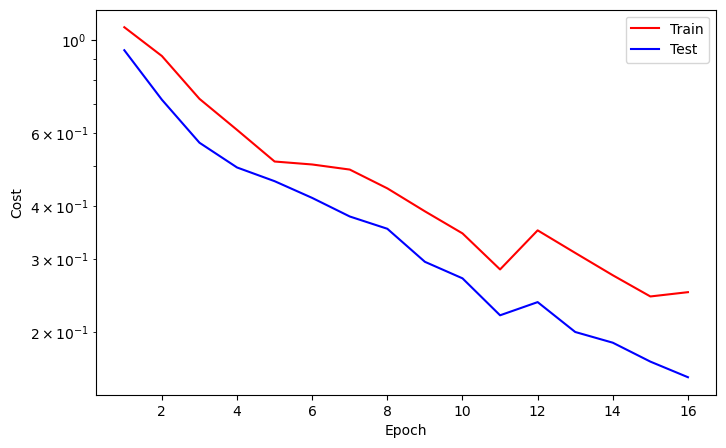

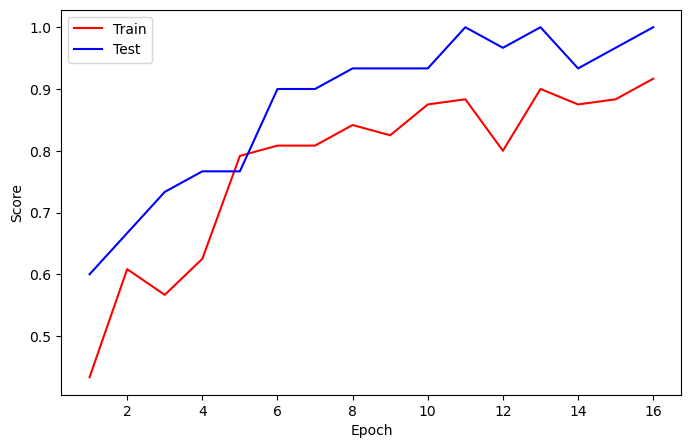

In [38]:
while True:
    train_cost, train_score = loop_fn('train', train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost, test_score = loop_fn('test', test_set, testloader, model, criterion, optimizer, device)
    # logging
    callback.log(train_cost, test_cost, train_score, test_score)
    
    # Checkpoint
    callback.save_checkpoint()
    
    # RunTime Plotting
    callback.cost_runtime_plotting()
    callback.score_runtime_plotting()
    
    # Early Stopping
    if callback.early_stopping(model, monitor='test_score'):
        callback.plot_cost()
        callback.plot_score()
        break

# Load best model

In [39]:
weights = torch.load('modelMCCIris/weights_best.pth', map_location='cpu')

model = MCCIris(4, 6, 3, 0.2).to(device)
model.load_state_dict(weights)
model = model.to(device)

In [40]:
model

MCCIris(
  (fc): Sequential(
    (0): Sequential(
      (0): Linear(in_features=4, out_features=6, bias=True)
      (1): Sigmoid()
      (2): Dropout(p=0.2, inplace=False)
    )
    (1): Sequential(
      (0): Linear(in_features=6, out_features=3, bias=True)
      (1): LogSoftmax(dim=1)
    )
  )
)

# Predict

In [41]:
feature, target = next(iter(testloader))
feature, target = feature.to(device), target.to(device)

In [42]:
label = {0:'setosa', 1:'versicolor', 2:'virginica'}

In [43]:
pip install termcolor

Note: you may need to restart the kernel to use updated packages.


In [45]:
from termcolor import colored

In [46]:
with torch.no_grad():
    model.eval()
    output = model(feature) 
    preds = output.argmax(1)


In [56]:
predictions = preds.tolist()
targets = target.tolist()

In [61]:
for i in range (len(predictions)):
    if predictions[i] == targets[i]:
        print(colored(label[targets[i]], 'green'))
    else:
        print(colored(label[targets[i]], 'red'))

setosa
virginica
versicolor
versicolor
setosa
versicolor
setosa
setosa
virginica
versicolor
virginica
virginica
virginica
versicolor
setosa
setosa
setosa
versicolor
versicolor
virginica
setosa
virginica
versicolor
virginica
virginica
versicolor
versicolor
setosa
virginica
setosa
